In [2]:

from transformers import AutoProcessor, AutoModel
import os
import torch
import random
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

In [3]:
def get_random_cub_images(n: int, directory: str) -> list:
    """ Get n random images as PIL Image objects from the cub dataset for testing purposes """
    
    images_dir = os.path.join(directory, "images")
    classes = os.listdir(images_dir)
    
    random_classes = random.choices(classes, k=n)
    
    random_images = []  
    for cls in random_classes:
        cls_dir = os.path.join(images_dir, cls)
        images = os.listdir(cls_dir)
        random_images.append(Image.open(os.path.join(cls_dir, random.choice(images))))
        
    return random_images

In [4]:
def plot_images_two_rows(images_top: list[torch.tensor], images_low: list[torch.tensor]):
    """ Plot two rows of images """
    images_ = images_top + images_low
    n = len(images_top)
    fig, ax = plt.subplots(2, n, figsize=(8, 5))
    
    for i, img in enumerate(images_):
        ax[i//n, i%n].imshow(img)
        ax[i//n, i%n].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
images = get_random_cub_images(3000, "./../datasets/CUB_200_2011")

In [6]:

def most_least_concept_similarity_siglip(model: torch.nn.Module, processor: torch.nn.Module, images: list[torch.tensor], concept: str, device: str = "cuda") -> tuple:
    """ Get the 3 images indices that most ressemble a concept and the 3 that least ressemble it for clip"""
    most, least = [], []

    with torch.no_grad():
        inputs = processor(images = images, text = [concept], return_tensors="pt", padding="max_length").to(device)
        
        output = model(**inputs)
        probs = torch.sigmoid(output.logits_per_text).cpu().numpy()

    most = probs.argsort(axis=1)[0, -3:]
    least = probs.argsort(axis=1)[0, :3]
    
    return most, least
    

In [7]:

siglip_model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
siglip_processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

siglip_model.to(device)

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768

In [8]:
import inspect

siglip_model_file = inspect.getfile(siglip_model.__class__)
print(siglip_model_file)

/Data/hugo.aoyagi/micromamba/envs/viscoin/lib/python3.12/site-packages/transformers/models/siglip/modeling_siglip.py


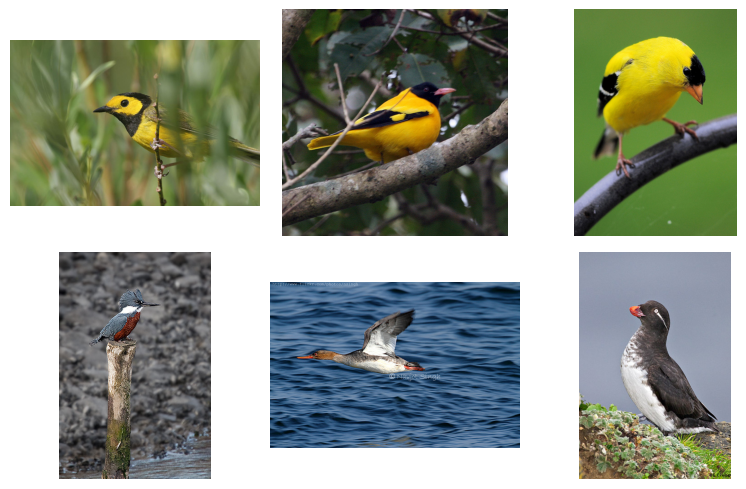

In [9]:
most, least = most_least_concept_similarity_siglip(siglip_model, siglip_processor, images[:1000], "a picture of a yellow bird with black eyes", device)

plot_images_two_rows([images[i] for i in most], [images[i] for i in least])

In [10]:
def forward_difference(
    model: torch.nn.Module,
    processor: torch.nn.Module,
    image_a: torch.tensor,
    image_b: torch.tensor,
    labels: list[str],
    device: str = "cuda",
):
    # Use SigLIP model's config for some fields (if specified) instead of those of vision & text components.
    output_attentions = model.config.output_attentions
    output_hidden_states = model.config.output_hidden_states
    return_dict = model.config.use_return_dict
    
    inputs = processor(images = [image_a, image_b], text = labels, return_tensors="pt", padding="max_length").to(device)

    vision_outputs = model.vision_model(
        pixel_values=inputs.pixel_values,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        interpolate_pos_encoding=False,
    )

    text_outputs = model.text_model(
        input_ids=inputs.input_ids,
        attention_mask=None,
        position_ids=None,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )

    image_embeds_a = vision_outputs[1][0]
    image_embeds_b = vision_outputs[1][1]
    text_embeds = text_outputs[1]
    
    image_embeds = (image_embeds_b - image_embeds_a).unsqueeze(0)

    # normalized features
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    # cosine similarity as logits
    logits_per_text = (
        torch.matmul(text_embeds, image_embeds.t().to(text_embeds.device)) * model.logit_scale.exp()
        + model.logit_bias
    )
    logits_per_image = logits_per_text.t()

    return (logits_per_image, logits_per_text)

def forward(model, processor, image, texts):
    inputs = processor(images = [image], text = texts, return_tensors="pt", padding="max_length").to(device)
    
    output = model(**inputs)
    
    return (output.logits_per_image, output.logits_per_text)

In [11]:
def get_best_labels(model: torch.nn.Module, processor: torch.nn.Module, image: torch.tensor, labels: list[str]) -> list:
    with torch.no_grad():
        logits_per_image, logits_per_text = forward(model, processor, image, labels)
        probs = torch.sigmoid(logits_per_image).cpu().numpy()
    best = probs.argsort(axis=1)[0, -3:][::-1]
    return [(i, probs[0, i]) for i in best]

def get_best_labels_diff(model: torch.nn.Module, processor: torch.nn.Module, image_a: torch.tensor, image_b: torch.tensor, labels: list[str]) -> list:
    with torch.no_grad():
        logits_per_image, logits_per_text = forward_difference(model, processor, image_a, image_b, labels)
        probs = torch.sigmoid(logits_per_image).cpu().numpy()
    best = probs.argsort(axis=1)[0, -3:][::-1]
    return [(i, probs[0, i]) for i in best]

In [18]:
def load_vocab(file_path: str) -> list:
    with open(file_path, 'r') as f:
        labels = f.readlines()
    labels = [label.strip() for label in labels]
    return labels

labels = load_vocab("vocab/example_labels.txt")

In [13]:

def plot_embedding_diff(model: torch.nn.Module, processor: torch.nn.Module, image_a: Image, image_b: Image, labels: list[str]):
    """
    Plots the two images and prints the 3 best labels for each image and the difference between them, prints each label and the normalized cosine similarity
        
        Parameters:
            model: CLIP model
            image_i (PIL Image): Image A or B
            labels: List of labels
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    ax[0].imshow(image_a)
    ax[0].axis("off")
    ax[1].imshow(image_b)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

    print("Best labels for image A:")
    for best in get_best_labels(model, processor, image_a, labels):
        print(labels[best[0]], best[1])

    print("\nBest labels for image B:")
    for best in get_best_labels(model, processor, image_b, labels):
        print(labels[best[0]], best[1])
        
    print("\nBest labels for the difference between image A and B:")
    for best in get_best_labels_diff(model, processor, image_a, image_b, labels):
        print(labels[best[0]], best[1])


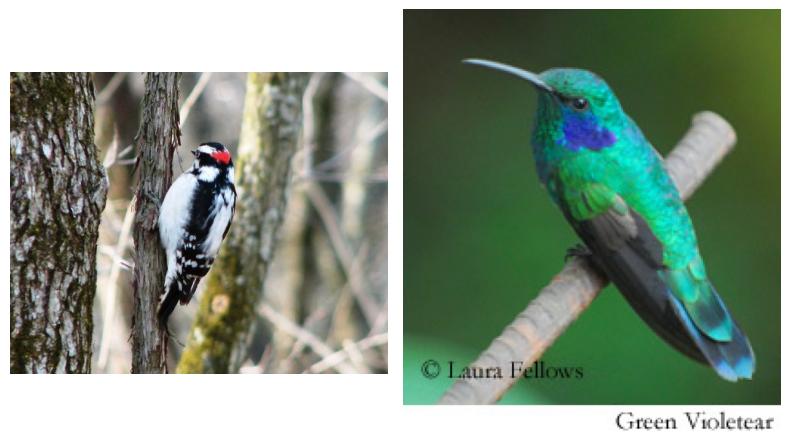

Best labels for image A:
Spotted back 0.14722525
Spotted beak 0.04230422
Spotted tail 0.04001681

Best labels for image B:
Green wings 0.087006405
Green neck 0.03270344
Green tail 0.018483689

Best labels for the difference between image A and B:
Green wings 0.630435
Green neck 0.04242482
Green feathers 0.024078662


In [14]:
#Indices of the two images to compare
a, b = random.randint(0, len(images)), random.randint(0, len(images))

plot_embedding_diff(siglip_model, siglip_processor, images[a], images[b], labels)

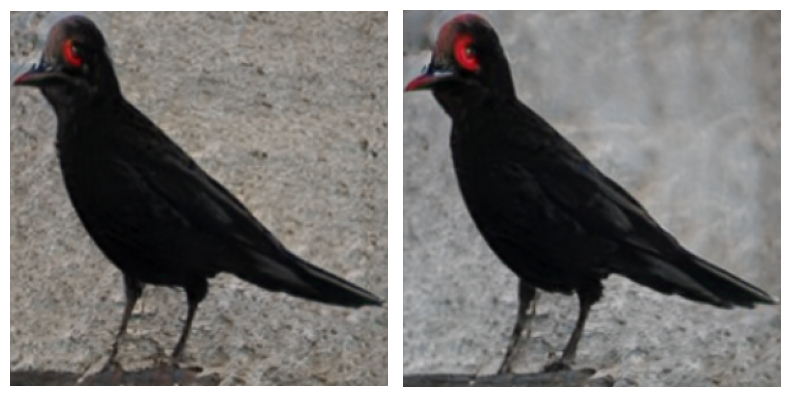

Best labels for image A:
Red beak 0.15990865
Short beak 0.043930165
Thick beak 0.03910591

Best labels for image B:
Red beak 0.15645723
Short beak 0.035864204
Thick beak 0.027465941

Best labels for the difference between image A and B:
Yellow tail 0.0018341864
Magenta 0.00080496795
Spotted back 0.00035042907


In [ ]:
image_lbd1 = Image.open("images/redeye-lbd1.png")
image_lbd4 = Image.open("images/redeye-lbd4.png")

image_lbd1 = np.array(image_lbd1)[:, :, :3]
image_lbd4 = np.array(image_lbd4)[:, :, :3]

plot_embedding_diff(siglip_model, siglip_processor, image_lbd1, image_lbd4, labels)